In [52]:
%reset -f
import os
from cfg import Settings

import torch
import torchvision.datasets as datasets
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tensorboardX import SummaryWriter

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

# Constants

In [53]:
DATA_DIR = '../data/prepared/'
settings = Settings()
BATCH_SIZE, DEVICE_NAME = settings.get_params()
NUM_WORKERS = 0
#L_R = 1e-3
device = torch.device(DEVICE_NAME)

# Functions

In [54]:
def pt_loader(path):
    return torch.load(path)

def get_dataset(data_dir):
    dataset = datasets.DatasetFolder(data_dir, pt_loader, ['pt'])
    return dataset

def get_loader(name, data_dir, batch_size, num_workers=0):
    if name == 'train' or name == 'val':
        dataset = get_dataset(data_dir=os.path.join(data_dir, name))
        loader = torch.utils.data.DataLoader(
                dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True, pin_memory=True, sampler=None, drop_last=True
        )
        return loader
    else:
        raise NotImplemented

# Net

In [55]:
class SpoofNet(nn.Module):
    def __init__(self):
        super(SpoofNet, self).__init__()
        
        self.resnet = torchvision.models.resnet18(pretrained=True)
        
        self.fc0 = nn.Linear(1000,500)
        self.fc1 = nn.Linear(500,250)
        self.fc2 = nn.Linear(250,125)
        self.fc3 = nn.Linear(125,50)
        self.fc4 = nn.Linear(50,25)
        self.fc5 = nn.Linear(25,1)
        
    def fully_conected(self ,x):
        
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        x = torch.sigmoid(self.fc5(x))
        
        return x
    
    def forward(self, x):
        x = self.resnet(x)
        out = self.fully_conected(x)
        return out
    
# Convolutional neural network
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(56*56*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(5),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(5, 7, kernel_size=5, stride=2, padding=1),
            #nn.BatchNorm2d(7),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(7, 9, kernel_size=5, stride=2, padding=2),
            #nn.BatchNorm2d(9),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(9, 11, kernel_size=5, stride=2, padding=2),
            #nn.BatchNorm2d(11),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(11, 13, kernel_size=5, stride=2, padding=2),
            #nn.BatchNorm2d(13),
            nn.ReLU())
        self.fc = nn.Linear(7*7*13, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = torch.sigmoid(self.fc(out))
        return out

# Define data loaders

In [56]:
train_loader = get_loader('train', DATA_DIR, BATCH_SIZE, NUM_WORKERS)
val_loader = get_loader('val', DATA_DIR, BATCH_SIZE, NUM_WORKERS)

# Define model

In [104]:
model = ConvNet2()
#model = torch.load('checkpoints/ResNet50-epoch-11.pt')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
torch.cuda.empty_cache()
model = model.to(device)
log_writer = SummaryWriter(log_dir='logs/7-200epoch/')

# Training

In [105]:
itter = 0
for epoch in range(201):
    created = False
    for x,y in train_loader:
        x , y = x.to(device) , y.to(device)
        
        output = model(x)
        loss = criterion(output,y.float())
        
        if not created:
            outputs = output
            trues = y.float()
            created = True
        else:
            outputs = torch.cat((outputs,output))
            trues = torch.cat((trues,y.float()))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        log_writer.add_scalar('train/loss', loss.item(), itter)
        itter +=1
        
    predictions = (outputs.cpu().data.numpy() > 0.5).astype(int)
    train_accuracy = (predictions.T == trues.cpu().data.numpy().astype(int)).mean()
    log_writer.add_scalar('train/accuracy', train_accuracy, itter)
    
    with torch.no_grad():
        created = False
        for x_val,y_val in val_loader:
            x_val, y_val = x_val.to(device) , y_val.to(device)
            output = model(x_val)

            if not created:
                outputs = output
                trues = y_val.float()
                created = True
            else:
                outputs = torch.cat((outputs,output))
                trues = torch.cat((trues,y_val.float()))

        val_loss = criterion(outputs,trues)
        #val_metrics = roc_auc_score(trues.int().cpu().data.numpy(),outputs.cpu().data.numpy())
        predictions = (outputs.cpu().data.numpy() > 0.5).astype(int)
        val_accuracy = (predictions.T == trues.cpu().data.numpy().astype(int)).mean()

        log_writer.add_scalar('val/loss', val_loss.item(), itter)
        #log_writer.add_scalar('val/metrics', val_metrics, itter)
        log_writer.add_scalar('val/accuracy', val_accuracy, itter)
        
    print('epoch',epoch,'finished')
    if (epoch) % 10 == 0:torch.save(model, os.path.join('checkpoints', 'MyConvNet-epoch-'+str(epoch+1)+'.pt'))
        
log_writer.close()

C:\Users\olexd\Anaconda3\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\olexd\Anaconda3\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([192, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0 finished


C:\Users\olexd\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ConvNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished
epoch 50 finished
epoch 51 finished
epoch 52 finished
epoch 53 finished
epoch 54 finished
epoch 55 finished
epoch 56 finished
e

# Try single images

spoof probability: 0.97367555


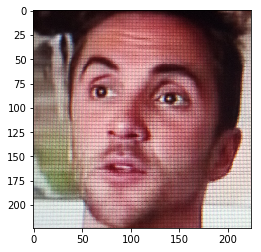

In [96]:
image_name = 'val/spoof/429'
image = torch.load('../data/prepared/' + image_name + '.pt').to(device)
plt.imshow(image.permute(1,2,0))
image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
pred = model.forward(image)
print('spoof probability:', pred.cpu().data.numpy()[0,0])